In [497]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import seaborn as sns
from matplotlib import pyplot as plt
from utils import plot_topic_volume
import matplotlib.dates as md
from src.colnames import topic_col
from collections import defaultdict
import itertools
from scipy.stats import spearmanr, pearsonr

import statsmodels.api as sm
import statsmodels.formula.api as smf


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [645]:
# preds.to_json('data/topic/data_renamed.jsonl', orient='records', lines=True)

### Extract best model

In [646]:
fit_on = 'eucomm'
eval_on = 'all'
MODEL_PATH = Path('logs') / 'topic' / fit_on / 'performances.jsonl'
models = pd.read_json(MODEL_PATH, orient='records', lines=True)

#### Create new column names

In [866]:
new_names = ['Economy and markets', 
             'Finance and trade',
             'Growth and Global Development',
             'Strategic Investments (e.g., recovery, research, innovation)', 
             'Health',
             "Citizen Rights and Integration", 
             "Human Rights", 
             'Digital Policy',
             'Digital and Green Transition', 
             'Energy, Sustainability and Climate',
             'Identity, Culture and Citizen Engagement', 
             "Citizen Initiatives",
             'Visions for the Future',
             'Internal Governance',
             'Trade, Partnerships, and Law', 
             'Solidarity and Emergency Response', 
             'Financial Aid',
             'Press conferences and Statements',
             'Charts, Links, Infographics', 
             'Live Events']
old_names = ['economy_and_markets', 
             'finance_and_trade',
             'global_goals',
             'investments_recovery_growth_and_innovation', 
             'health',
             'citizens_rights_and_regulations',
             'human_rights', 
             'digital_policy',
             'digital_and_green_transition', 
             'sustainability_energy_and_climate',
             'identity_and_culture',
             'citizens_engagement_and_culture',
             'vision_for_the_future',
             'governance_and_international_relations',
             'eu_policies_and_partnerships', 
             'humanitarian_support_and_refugees', 
             'humanitarian_financial_aid', 
             'press_conferences_and_statements', 
             'charts_links_and_infographics', 
             'live_events']
categories = ['Economic and Financial Policy'] * 4 + \
             ['Social Policy'] * 3 + \
             ['Environmental and Digital Policy'] * 3 + \
             ['Identity and Citizen Participation'] * 3 + \
             ['Governance'] * 2 + \
             ['Solidarity and Humanitarian Aid'] * 2 + \
             ['Communication and Media'] * 3

new_to_old = dict(zip(new_names, old_names))
old_to_new = dict(zip(old_names, new_names))
new_to_cat = dict(zip(new_names, categories))
cats = defaultdict(list)
for i,c in enumerate(categories):
    cats[c].append(new_names[i])

In [867]:
best = models[(models['split']=='test') & (models['entity']==eval_on)].sort_values(by='npmi_10', ascending=False)
BEST_MODEL = best.name.tolist()[0]
BEST_RUN = best.run.tolist()[0]
BEST_PATH = Path('models') / 'topic' / fit_on / BEST_MODEL / f'run-{BEST_RUN}' / 'model.json'
PRED_PATH = Path('logs') / 'topic' / fit_on / BEST_MODEL / f'run-{BEST_RUN}' / 'preds.jsonl'
topics = json.load(open(BEST_PATH))
preds = pd.read_json(PRED_PATH, orient='records', lines=True)
preds['top_topic'] = np.argmax(preds[[f'topic_{i}' for i in range(20)]].values, axis=1)
preds['top_topic'] = preds['top_topic'].apply(lambda x: f'topic_{str(x)}')
preds['confidence'] = np.max(preds[[f'topic_{i}' for i in range(20)]].values, axis=1)

#### Rename columns and compute aggregate values for each macro-category

In [872]:
# Rename columns
for i in range(20):
    preds = preds.rename({f'topic_{i}': topic_col[i]}, axis=1)
    preds = preds.rename(old_to_new, axis=1)

# Compute the m
for k,v in cats.items():
    preds[k] = preds[v].sum(axis=1)
    
# Replace top_topic
preds.replace(mapping).replace(old_to_new)
    
# Also compute a long version
preds_long = pd.melt(preds, id_vars='entity', value_vars=new_names)

In [873]:
for n in new_names:
    top_10 = preds[preds['entity']=='EU_Commission'].sort_values(by=n, ascending=False).head(n=10).text.tolist()
    topdf = pd.DataFrame(zip([n]*10, top_10), columns=['topic', 'text'])
    if n == new_names[0]:
        tdf = topdf
    else:
        tdf = pd.concat([tdf, topdf], axis=0)
with open('summaries/top_tweets.txt', 'w') as tfile:
    tfile.write(tdf.to_latex())

In [652]:
#for i,k in enumerate(preds.sort_values(by=f'digital_policy', 
#                                       ascending=False).head(n=20).text.tolist()):
#    print(f'{i+1}. {k}\n')

### Plot topics over time
Let's plot topic volume over time, at different levels of granularity (each topics vs. macro-categories)

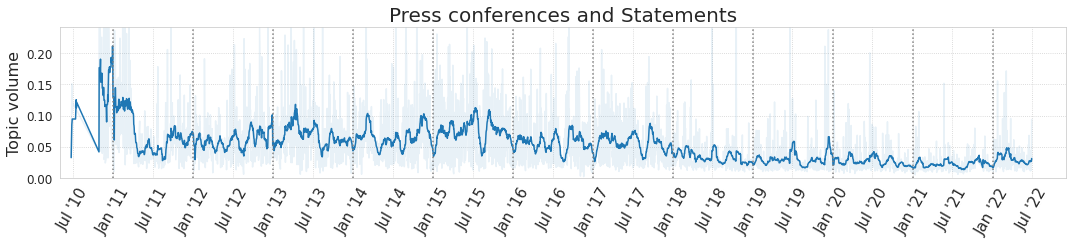

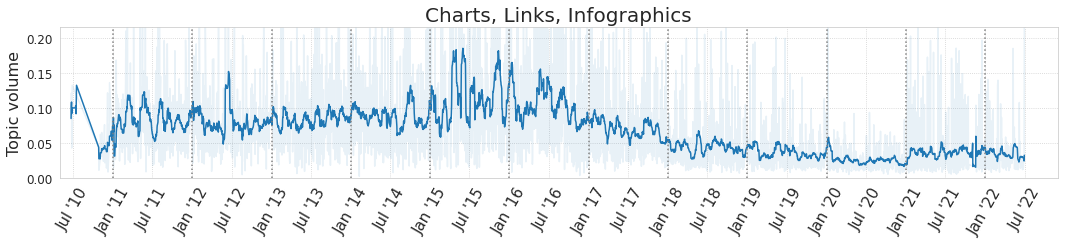

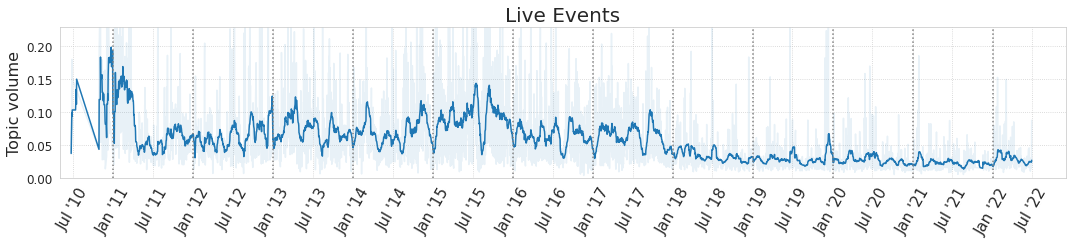

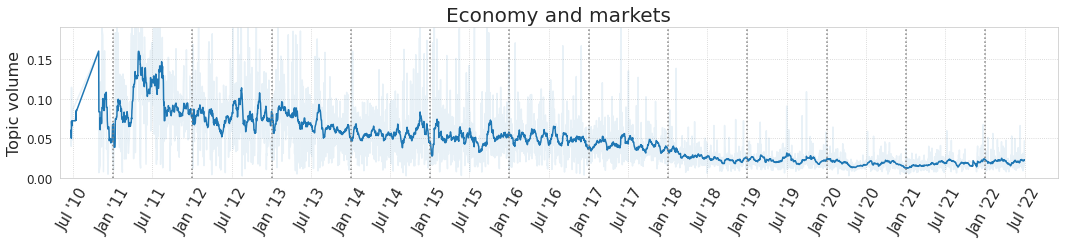

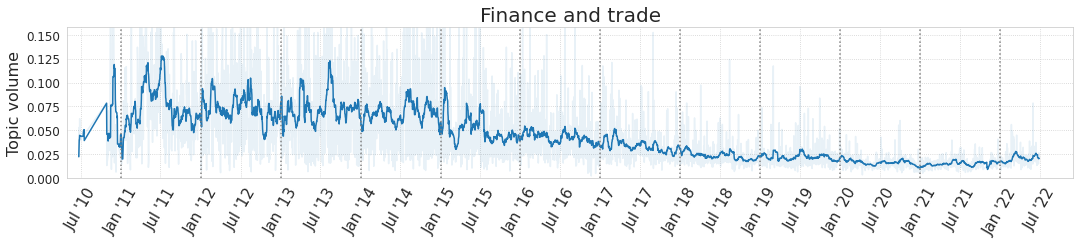

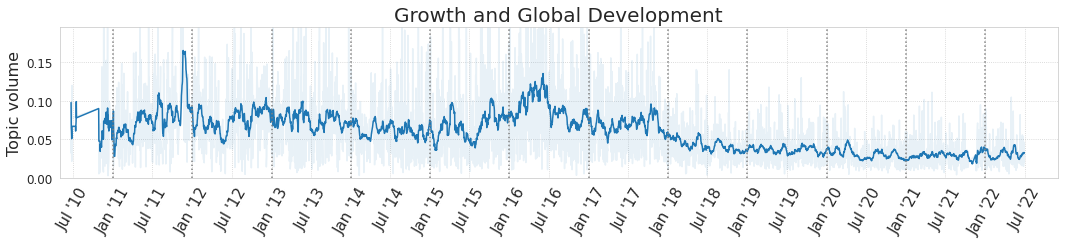

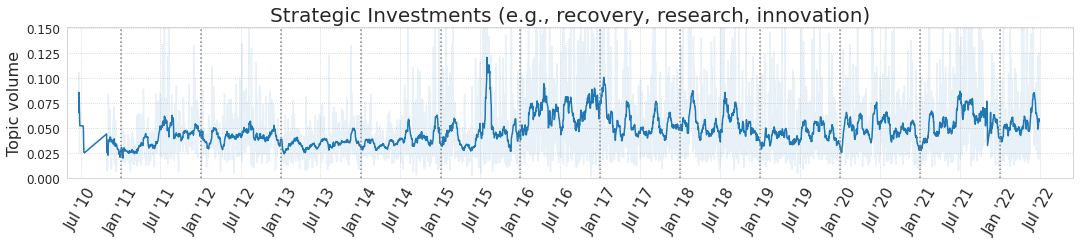

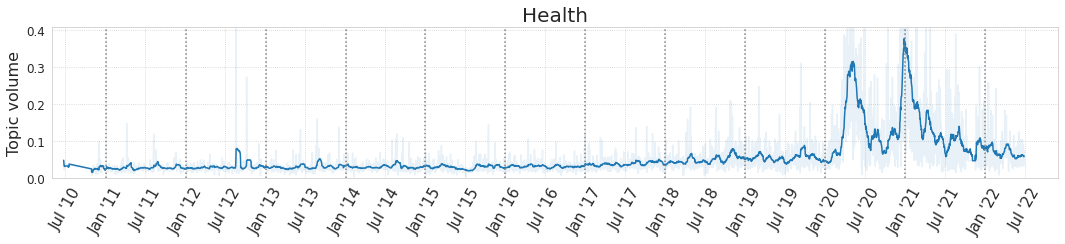

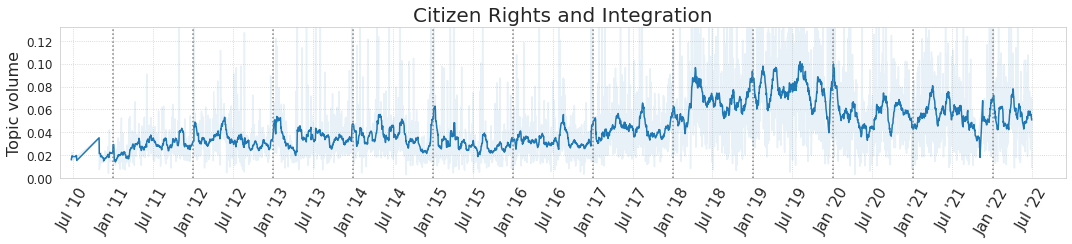

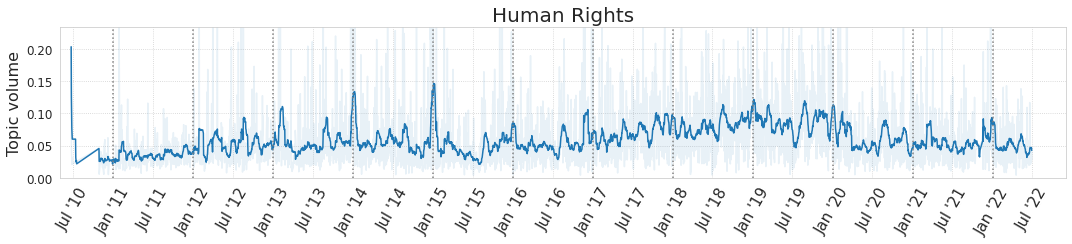

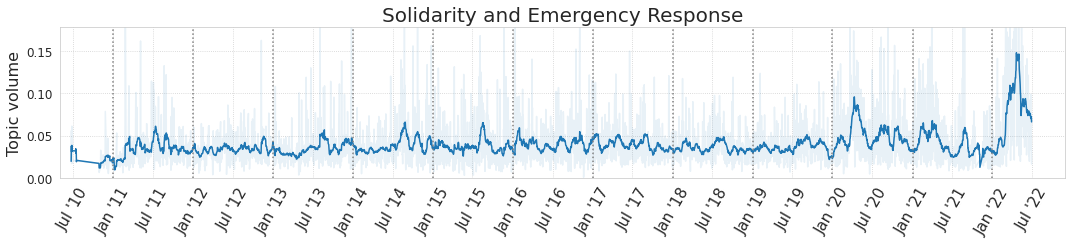

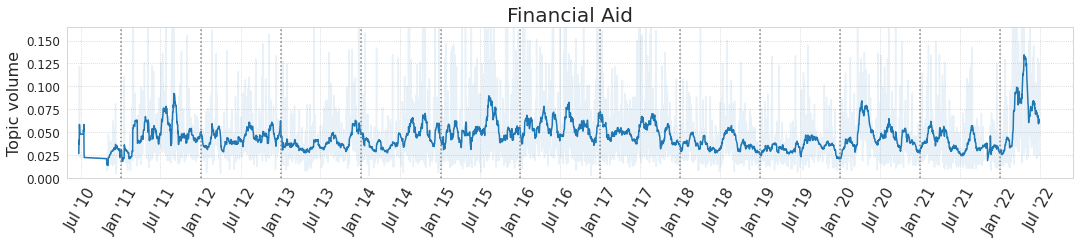

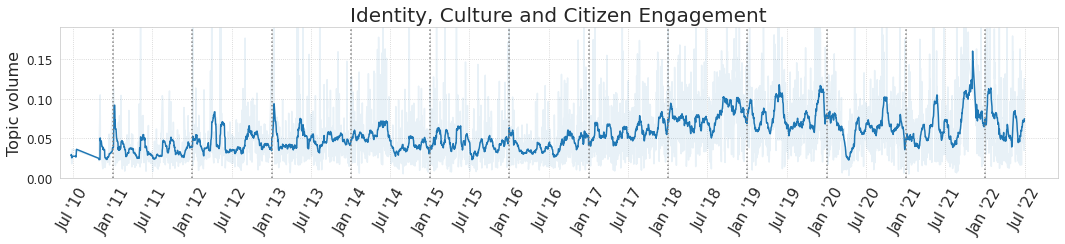

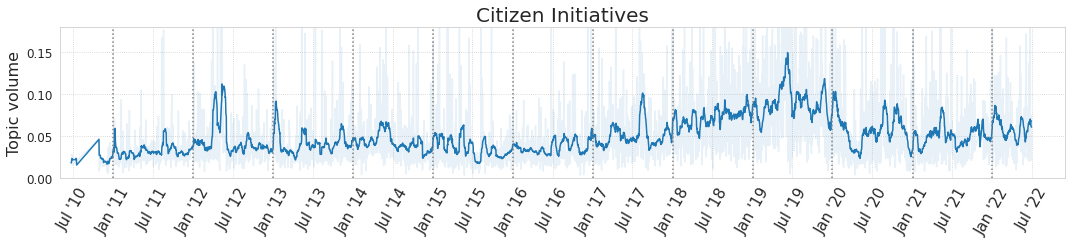

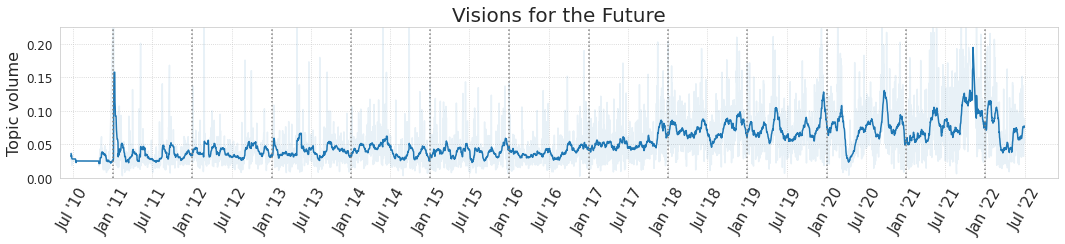

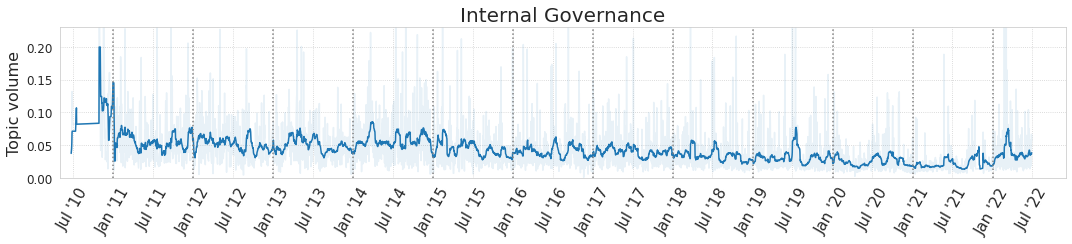

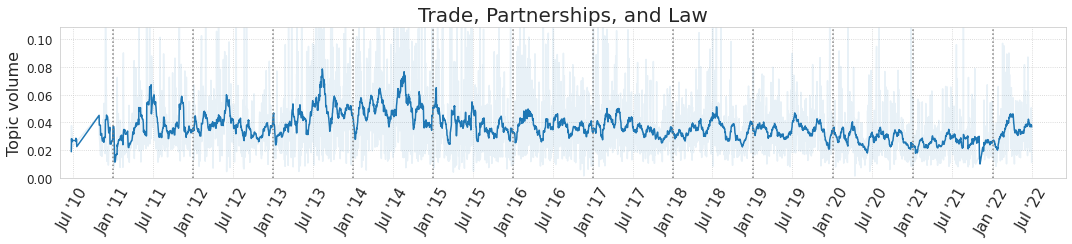

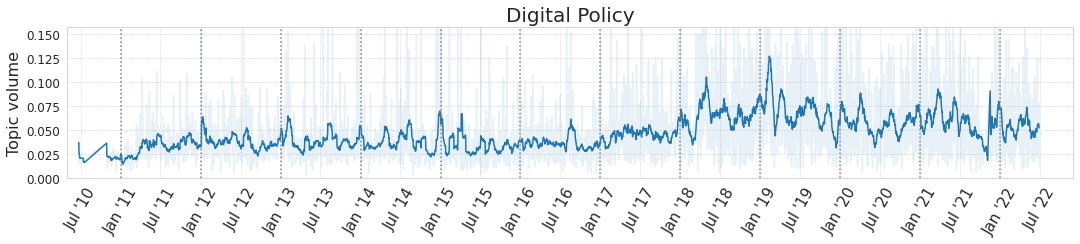

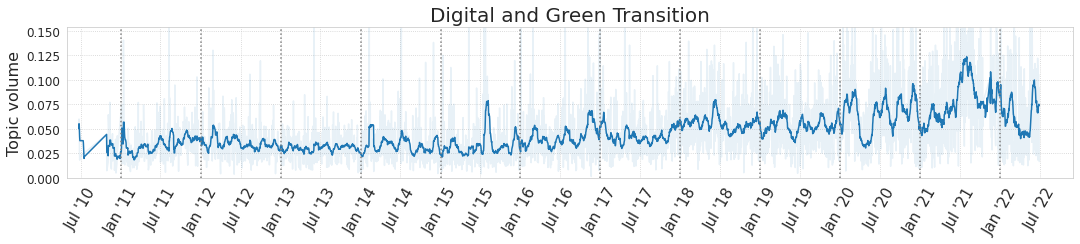

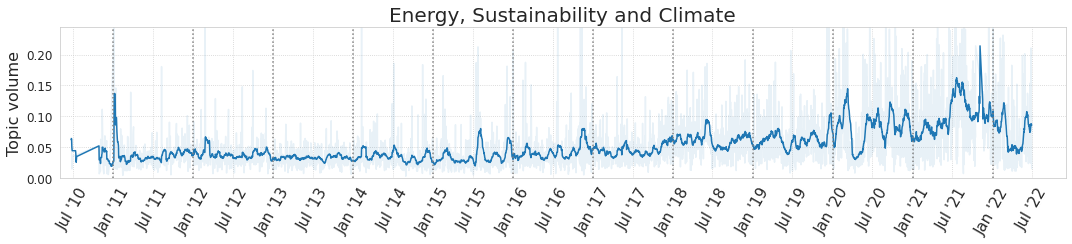

In [845]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
for t in set(categories):
    for k in cats[t]:
        plot_topic_volume(preds, 
                          entity='EU_Commission',
                          topics=new_names,
                          freq='D', roll_window=21,
                          savename=f'micro_volumes/{k}', interactive=False,
                          exclude_topics=set(new_names) - set([k]),
                          title=k,
                          # ylim=(0,ylim),
                          figsize=(15,3.5),
                          plot_smooth_only=False, 
                          xticksize=15)

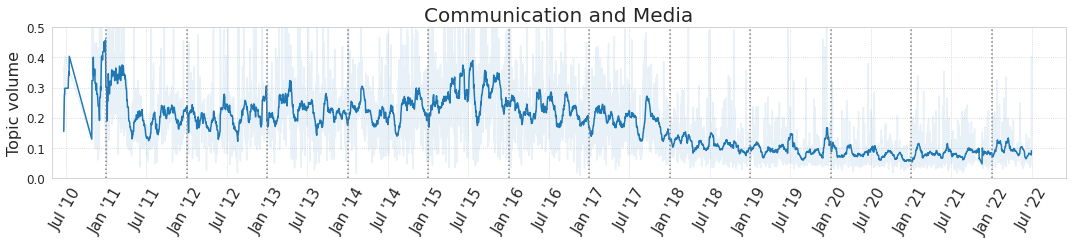

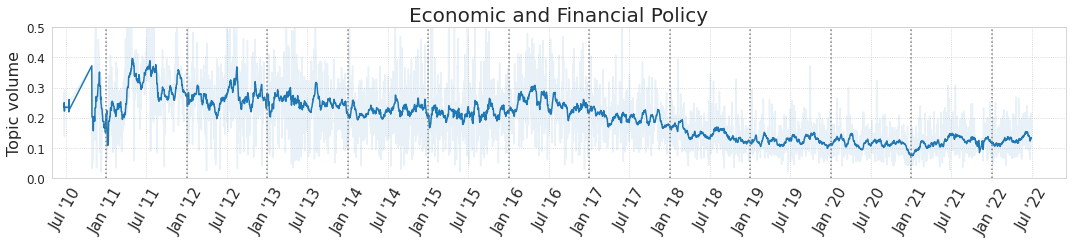

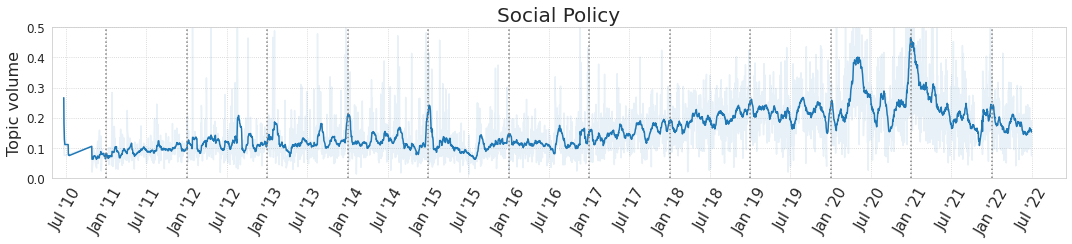

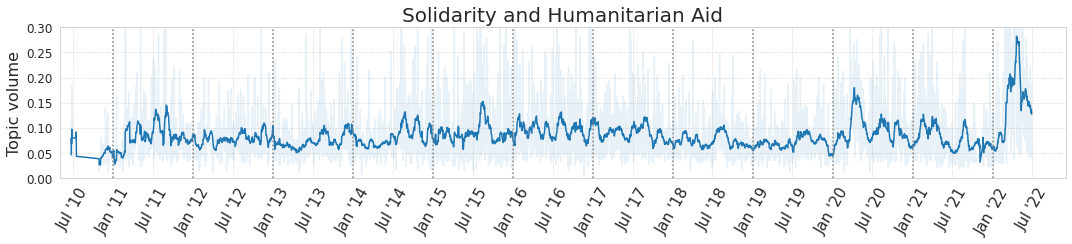

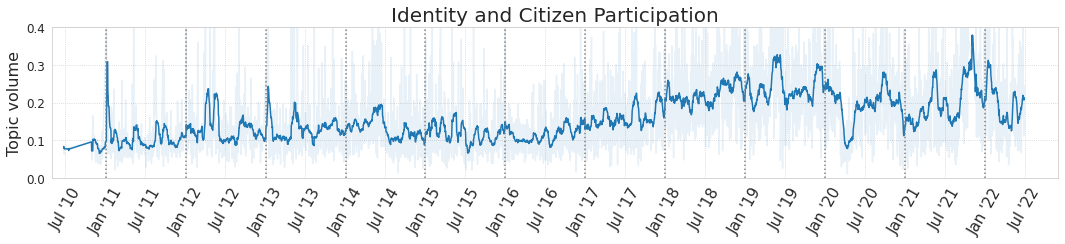

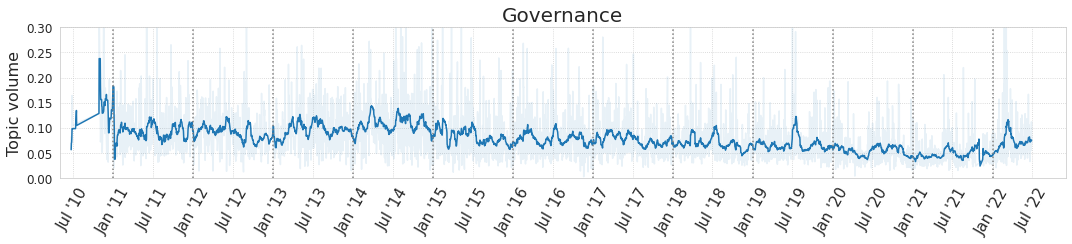

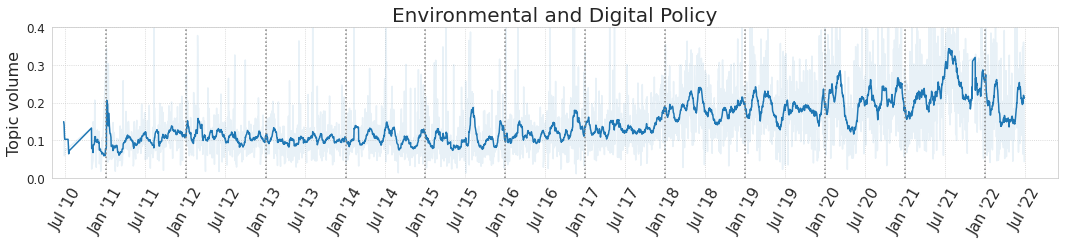

In [846]:
ylims = [0.5, .5, .5, .3, .4, .3, .4]
for i, t in enumerate(set(categories)):
    plot_topic_volume(preds,
                      entity='EU_Commission',
                      topics=categories,
                      freq='D', roll_window=21,
                      savename=f'macro_volumes/{t}', interactive=False,
                      exclude_topics=set(categories) - set([t]),
                      title=t,
                      figsize=(15,3.5),
                      ylim=(0, ylims[i]),
                      plot_smooth_only=False, xticksize=15)

#### Display average volume over time, simpler visualization

In [874]:
preds['year'] = preds['created_at'].apply(lambda x: x.year)
preds['month'] = preds['created_at'].apply(lambda x: x.month)
preds['day'] = preds['created_at'].apply(lambda x: x.day)

In [875]:
counts = preds.rename(mapping, axis=1)[preds['entity']=='EU_Commission'].groupby(['top_topic', 'year'])['text'].agg(lambda x: x.count()).reset_index() # get counts per topic
overall = preds.rename(mapping, axis=1)[preds['entity']=='EU_Commission'].groupby(['year'])['text'].agg(lambda x: x.count()).reset_index() # get overall counts
overall = overall.rename({'text': 'ov'}, axis=1) 
counts = counts.merge(overall)
counts['text'] = counts['text']/counts['ov'] # compute proportions
counts['top_topic'] = counts['top_topic'].apply(lambda x: old_to_new[mapping[x]]) # new names
counts = counts.sort_values(by='text') # sort values
counts['group'] = counts['top_topic'].replace(new_to_cat) # add macro-categories

In [881]:
preds['top_topic_renamed'] = preds['top_topic'].apply(lambda x: topic_col[int(x.split('_')[1])])

year  top_topic_renamed                         
2008  charts_links_and_infographics                   0.241546
      citizens_engagement_and_culture                 0.000000
      digital_and_green_transition                    0.000000
      economy_and_markets                             0.111111
      eu_policies_and_partnerships                    0.000000
                                                       ...    
2022  investments_recovery_growth_and_innovation    230.267123
      live_events                                   338.184615
      press_conferences_and_statements              301.131737
      sustainability_energy_and_climate             193.207237
      vision_for_the_future                         313.594595
Name: sum_count, Length: 298, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'charts_links_and_infographics'),
  Text(1, 0, 'citizens_rights_and_regulations'),
  Text(2, 0, 'economy_and_markets'),
  Text(3, 0, 'finance_and_trade'),
  Text(4, 0, 'global_goals'),
  Text(5, 0, 'governance_and_international_relations'),
  Text(6, 0, 'human_rights'),
  Text(7, 0, 'humanitarian_financial_aid'),
  Text(8, 0, 'humanitarian_support_and_refugees'),
  Text(9, 0, 'investments_recovery_growth_and_innovation'),
  Text(10, 0, 'live_events'),
  Text(11, 0, 'press_conferences_and_statements'),
  Text(12, 0, 'sustainability_energy_and_climate'),
  Text(13, 0, 'vision_for_the_future'),
  Text(14, 0, 'citizens_engagement_and_culture'),
  Text(15, 0, 'digital_and_green_transition'),
  Text(16, 0, 'digital_policy'),
  Text(17, 0, 'eu_policies_and_partnerships'),
  Text(18, 0, 'health'),
  Text(19, 0, 'identity_and_culture')])

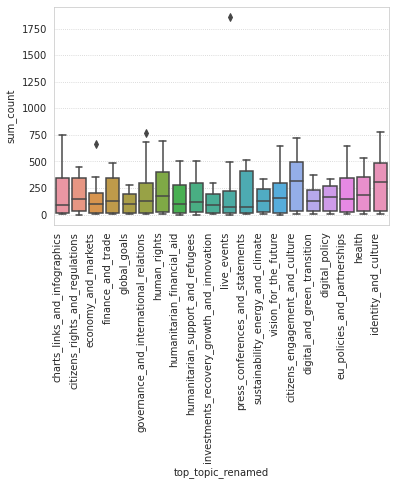

In [896]:
sns.boxplot(data=preds[preds['entity']=='EU_Commission'].groupby(['year', 'top_topic_renamed']).sum_count.mean().reset_index(),
            y='sum_count', x='top_topic_renamed')
plt.xticks(rotation=90, ha='right')

Flattening the topic list, for simplicity.

In [758]:
no = []
for k in cats.values():
    for a in k:
        if 'Strategic' not in a:
            no.append(a)
        else:
            no.append('Strategic Investments')

Now, plotting the average volume per year

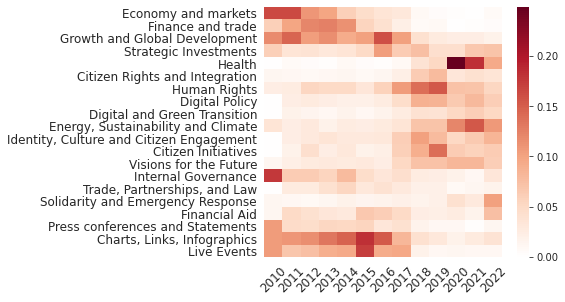

In [908]:
counts = counts.replace({'Strategic Investments (e.g., recovery, research, innovation)': 
                         'Strategic Investments'})
wide = pd.pivot(counts, 
                index='top_topic', 
                columns='year', 
                values='text').fillna(0)
wide = wide.T[no].T
plt.subplots(figsize=(8,4.3))
sns.heatmap(wide, 
            cmap='RdGy_r', 
            center=0)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('figs/topics_heatmap.png', dpi=300)
plt.show()

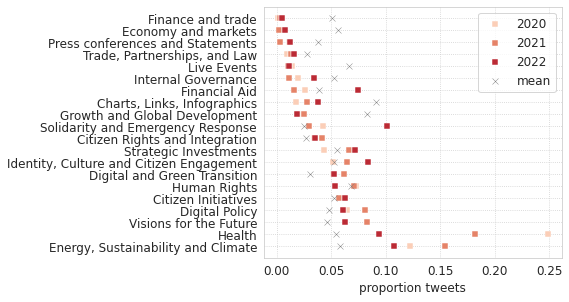

In [907]:
palette = sns.color_palette('RdGy', 7)[:-4][::-1]
#palette=['darkorange', 'grey', 'darkred']

plt.subplots(figsize=(8,4.3))
for i, y in enumerate([2020, 2021, 2022]):
    sns.scatterplot(data=counts[counts['year']>=y].sort_values(by='text'),
                    y='top_topic', x='text', marker='s',
                    label=y, color=palette[i])
sns.scatterplot(data=counts.groupby('top_topic').mean().reset_index().sort_values(by='text'),
                y='top_topic', x='text', color='grey', marker='x', label='mean')
plt.xlabel('proportion tweets', fontsize=12)
plt.ylabel('')
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig('figs/topics_scatter.png', dpi=300)
plt.show()

### Similarity with other agencies, over time

In [660]:
avg_vol = preds.groupby(['year', 'month', 'entity'])[new_names].mean().reset_index()

In [661]:
entities = list(itertools.combinations(preds.entity.unique(), 2))
cors = []
for year in preds.year.unique():
    for month in preds.month.unique():
        for e0, e1 in entities:
            if e0 == 'EU_Commission' or e1 == 'EU_Commission':
                s = []
                for e in [e0, e1]:
                    s.append(avg_vol[(avg_vol['year']==year) & \
                                     (avg_vol['month']==month) & \
                                     (avg_vol['entity']==e)][new_names].values)
                if len(s[0]) > 0 and len(s[1]) > 0: 
                    c = spearmanr(s[0][0],s[1][0]).correlation
                    if e0 == 'EU_Commission':
                        cors.append((year, month, e1, c)) 
                    else:
                        cors.append((year, month, e0, c)) 

Compute some naming and plotting utils

In [662]:
cor_df = pd.DataFrame(cors, columns=['year', 'month', 'entity', 'cor'])
cor_df['date'] = pd.to_datetime(cor_df[['year', 'month']].assign(day=1)).dt.strftime('%b \'%y')
vals = pd.to_datetime(cor_df[['year', 'month']].assign(day=1)).sort_values().dt.strftime('%b \'%y').unique()
dct = dict(zip(vals, range(vals.shape[0])))
cor_df['date_mapped'] = cor_df['date'].replace(dct)
cor_df = cor_df.sort_values(by='date_mapped')
inv_dct = dict(zip(dct.values(), dct.keys()))
cor_df['values'] = cor_df.groupby(['entity'])['cor'].transform(lambda x: x.rolling(3,1).mean())

Plot the data

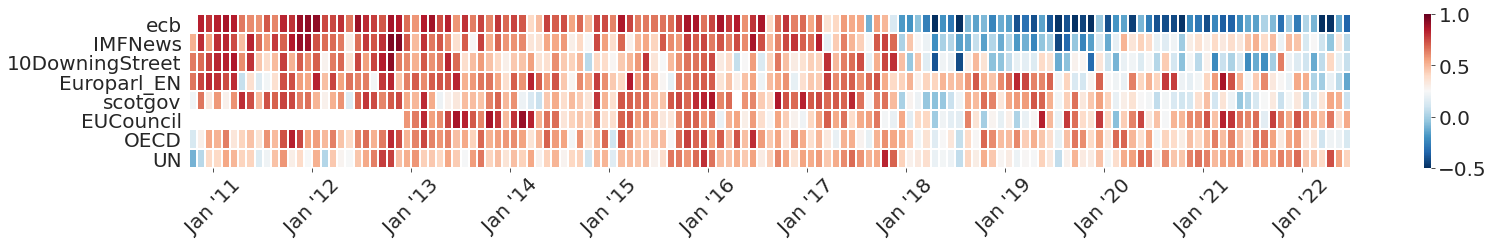

In [786]:
cc = cor_df.pivot(index='entity', columns='date_mapped', values='cor')
cc = cc.T[['UN', 'OECD', 'EUCouncil', 'scotgov', 'Europarl_EN', 
         '10DowningStreet', 'IMFNews', 'ecb'][::-1]]
cc = cc.T
plt.subplots(figsize=(23,3.5))
ax = sns.heatmap(cc, cmap='RdBu_r', 
                 vmin=-.5, vmax=1, linewidth=.005)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=20)
plt.xticks(ticks=np.arange(3,143,12),
           labels=[f'Jan \'{inv_dct[k][5:]}' for k in np.arange(3,143,12)],
           rotation=45, fontsize=20)
ax.xaxis.tick_bottom()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('figs/similarity_heatmap.png', dpi=300)
plt.show()

In [ ]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

for entity in ['UN', 'OECD', 'EUCouncil', 'scotgov', 'Europarl_EN', 
               '10DowningStreet', 'IMFNews', 'ecb'][::-1]:
    fig, ax = plt.subplots(figsize=(9,5))
    plt.title(f'{entity}', fontsize=14)
    edf = cor_df[cor_df['entity']==entity]
    sns.lineplot(data=edf, x='date_mapped', y='values', color='darkred')
    sns.lineplot(data=edf, x='date_mapped', y='cor', color='grey',
                 alpha=.2, marker='s')
    plt.xticks(ticks=[v for k,v in dct.items() if 'Jan' in k], 
               labels=[k for k,v in dct.items() if 'Jan' in k], 
               rotation=45, fontsize=12)
    plt.axhline(0, color='black', linestyle='dotted')
    plt.ylabel('topic similarity', fontsize=12)
    plt.xlim((edf['date_mapped'].dropna().min(), edf['date_mapped'].dropna().max()))
    plt.ylim(-.5,1)
    plt.xlabel('')
    sns.despine(left=False, right=False, top=False)
    plt.show()

### Aligning tweet volume to engagement

Extracting data: rank of topic in terms of volume and in terms of engagements

In [714]:
eng = preds.groupby(['entity', 
                     'year', 'month', 
                     'top_topic']).sum_count.agg(['count', 'median'])
eng = eng.reset_index()
eng = eng.replace(mapping).replace(old_to_new)
eng['date'] = pd.to_datetime(eng[['year', 'month']].assign(day=1)).dt.strftime('%b \'%y')
vals = pd.to_datetime(eng[['year', 'month']].assign(day=1)).sort_values().dt.strftime('%b \'%y').unique() # , 'month'
dct = dict(zip(vals, range(vals.shape[0])))
eng['date_mapped'] = eng['date'].replace(dct)

In [715]:
topics = eng.top_topic.unique()
ranks = []
for e in eng.entity.unique():
    ent_sub = eng[eng['entity']==e]
    for i in range(len(vals)-1):
        
        sub = ent_sub[ent_sub['date']==vals[i]]
        
        if sub.shape[0]>0:
            sub = sub.sort_values(by='median', ascending=False)
            sub_count = ent_sub[ent_sub['date']==vals[i+1]]
            if sub_count.shape[0]>0:
                sub_count = sub_count.sort_values(by='count', ascending=False)
                for t in topics:
                    idx = [i for i,tp in enumerate(sub.top_topic) if tp == t]
                    if len(idx) > 0:
                        idx = idx[0]
                    else:
                        idx = np.nan
                    idx_count = [i for i,tp in enumerate(sub_count.top_topic) if tp == t]
                    if len(idx_count) > 0:
                        idx_count = idx_count[0]
                    else:
                        idx_count = np.nan
                    ranks.append((e, vals[i+1], t, idx, idx_count))
rank_df = pd.DataFrame(ranks, columns=['entity', 'date', 
                                       'topic', 
                                       'rank_engagement', 'rank_nr']).dropna()

In [716]:
cors = []
for e in rank_df.entity.unique():
    ent_sub = rank_df[rank_df['entity']==e]
    for i in range(len(vals)-1):
        sub = ent_sub[ent_sub['date']==vals[i+1]]
        if sub.shape[0] > 1:
            c =  pearsonr(sub.rank_nr.tolist(),
                          sub.rank_engagement.tolist())[0] # .correlation
            cors.append((e, vals[i+1], c))

In [833]:
cordata = pd.DataFrame(cors, columns=['entity', 'date', 'value'])
cordata['month'] = cordata['date'].replace(dct)
coefdict = {}
for e in rank_df.entity.unique():
    sub = cordata[cordata['entity']==e].sort_values(by='month')
    mod = smf.ols(formula='value ~ month', data=sub)
    res = mod.fit()
    print(e, 'beta:', round(res.params[1],3), 'p:', round(res.pvalues[1],3)) 
    coefdict[e] = {'coeff': round(res.params[1],4),
                   'p': round(res.pvalues[1],3)}
    
    with open(f'summaries/alignment/{e}.txt', 'w') as t:
        t.write((res.summary().as_latex()))

cordata = cordata.rename({'value': 'Pearson\'s r'}, axis=1)

10DowningStreet beta: -0.0 p: 0.583
EUCouncil beta: 0.001 p: 0.484
EU_Commission beta: 0.004 p: 0.0
Europarl_EN beta: 0.002 p: 0.001
IMFNews beta: 0.001 p: 0.175
OECD beta: -0.0 p: 0.939
UN beta: 0.002 p: 0.009
ecb beta: -0.002 p: 0.001
scotgov beta: 0.001 p: 0.533


In [816]:
long_dct = dict(zip(range(cordata['date'].nunique() - 16), 
                    cordata[cordata['entity']=='10DowningStreet'].sort_values(by='month').date.tolist()[16:]))

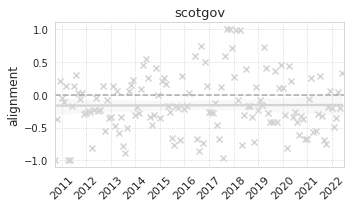

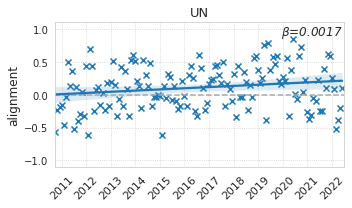

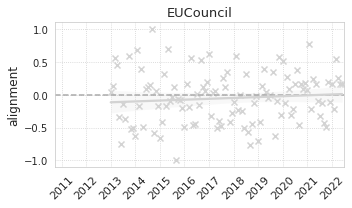

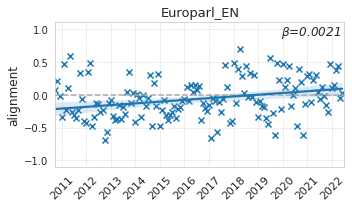

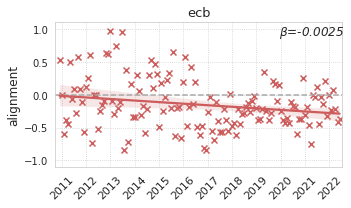

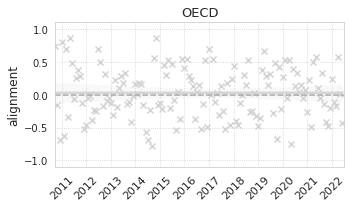

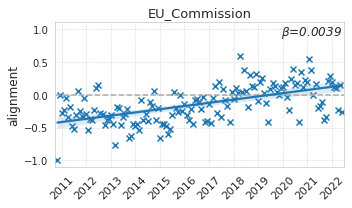

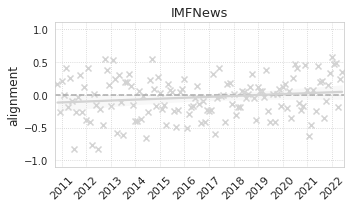

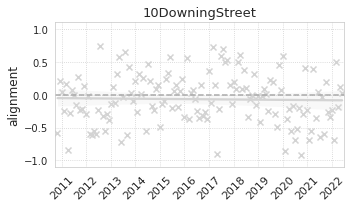

In [901]:
for e in preds.entity.unique():
    plt.subplots(figsize=(5,3))
    plt.axhline(linestyle='--', y=0, color='darkgrey')
    if coefdict[e]['p'] >= 0.05:
        color = 'lightgrey'
    elif coefdict[e]['coeff'] > 0:
        color = sns.color_palette()[0]
    else:
        color = 'indianred'
    sns.regplot(data=cordata[cordata['entity']==e][cordata['month']>=21], 
                x='month', y='Pearson\'s r', 
                marker='x',
                color=color,
                robust=True, scatter_kws={'color': color,
                                          'alpha': 1})
    plt.xlim(21,162)
    plt.ylim(-1.1,1.1)
    plt.xticks(ticks=np.arange(21+3,161,12),
               labels=[f'20{long_dct[k-21][5:]}' for k in np.arange(21+3,161,12)],
               rotation=45, fontsize=11)
    plt.xlabel('')
    plt.ylabel('alignment', fontsize=12)
    plt.title(e, fontsize=13)
    if not coefdict[e]['p']>=0.05:
        plt.annotate(xy=(131,0.9), style='italic', text=rf'$\beta$={coefdict[e]["coeff"]}', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'figs/alignment/{e}.png', dpi=300)
    plt.show()

Increasingly better at responding to user engagement.

#### Overall user engagement per topic

In [720]:
counts = rank_df.groupby(['topic']).rank_engagement.mean().reset_index().sort_values(by='rank_engagement')
grouped = preds.groupby('top_topic')[m]
d1 = grouped.sum().reset_index().sort_values(by=m).rename({'sum_count': 'median_engage'}, axis=1)
d2 = grouped.count().reset_index().sort_values(by=m).rename({'sum_count': 'count'}, axis=1)


In [721]:
merged = d1.merge(d2)
merged['ratio'] = merged['median_engage'] / merged['count']

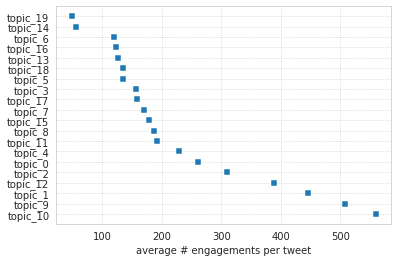

In [722]:
sns.scatterplot(data = merged.sort_values(by='ratio'), 
                y='top_topic', x='ratio', marker='s')
plt.xlabel(f'average # engagements per tweet')
plt.ylabel('')
plt.show()